In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as st
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
data=pd.read_csv('datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.Churn = labelencoder.fit_transform(data.Churn)
data.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Event is defined as the time at which the customer unsubscribe a marketing channel. 
Time of origin is defined as the time at which the customer starts the service / subscription of a marketing channel.
Time scale could be months, or weeks.

In [5]:
eventvar = data['Churn']
timevar = data['tenure']

In [6]:
#For the analysis, I will need to create dummy variables for all categorical variables.
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']

survival_data = pd.get_dummies(data, columns = categorical, drop_first= True)
survival_data.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,34,56.95,1889.5,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,45,42.30,1840.75,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [7]:
#drop variables such as customerID, tenure, Churn as they are not needed in survival data.
#Also, we need to add constant for survival analysis.
survival_data.drop(['customerID', 'tenure', 'Churn'], axis = 1, inplace= True)
survival_data = st.add_constant(survival_data, prepend=False)
survival_data.head()

,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,const
0,29.85,29.85,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1.0
1,56.95,1889.5,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1.0
2,53.85,108.15,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1.0
3,42.30,1840.75,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1.0
4,70.70,151.65,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,1.0


In [8]:
survival_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7043 non-null   float64
 1   TotalCharges                           7043 non-null   object 
 2   gender_Male                            7043 non-null   uint8  
 3   SeniorCitizen_1                        7043 non-null   uint8  
 4   Partner_Yes                            7043 non-null   uint8  
 5   Dependents_Yes                         7043 non-null   uint8  
 6   PhoneService_Yes                       7043 non-null   uint8  
 7   MultipleLines_No phone service         7043 non-null   uint8  
 8   MultipleLines_Yes                      7043 non-null   uint8  
 9   InternetService_Fiber optic            7043 non-null   uint8  
 10  InternetService_No                     7043 non-null   uint8  
 11  Onli

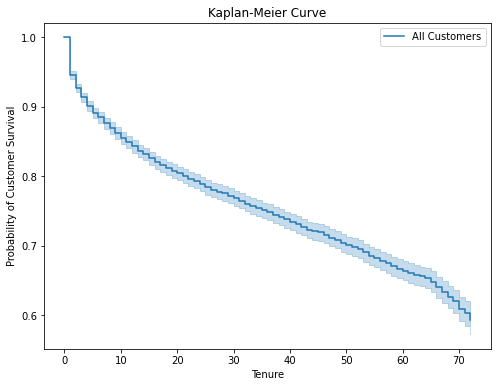

In [9]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All Customers")
#Plot the curve and assign labels
plt.figure(figsize=(8,6))
kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

As we can see, there is a sudden drop in the starting which says that after one tenure only customers starts churning rapidly and after that churning rate decreases. To deal with that we can consider giving more discounts on long-term plans and make more customers to subscribe for long term plans.

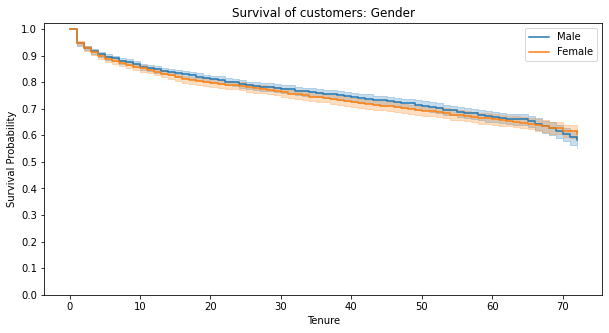

In [10]:
male = (survival_data['gender_Male'] == 1)
female = (survival_data['gender_Male'] == 0)

plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)

kmf.fit(timevar[male],event_observed = eventvar[male],label = "Male")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[female],event_observed = eventvar[female],label = "Female")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Gender')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[male], timevar[female], event_observed_A=eventvar[male], event_observed_B=eventvar[female])
groups.print_summary()

# Senior Citizen

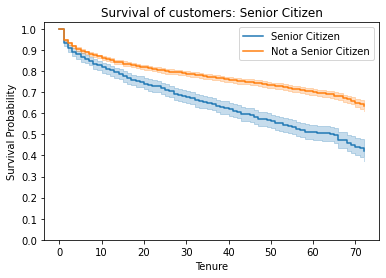

In [11]:
SeniorCitizen = (survival_data['SeniorCitizen_1'] == 1)
no_SeniorCitizen = (survival_data['SeniorCitizen_1'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[SeniorCitizen],event_observed = eventvar[SeniorCitizen],label = "Senior Citizen")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_SeniorCitizen],event_observed = eventvar[no_SeniorCitizen],label = "Not a Senior Citizen")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Senior Citizen')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[SeniorCitizen], timevar[no_SeniorCitizen], event_observed_A=eventvar[SeniorCitizen], event_observed_B=eventvar[no_SeniorCitizen])
groups.print_summary()

# Partner

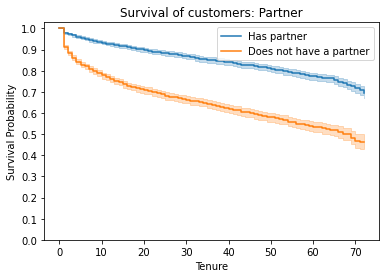

In [12]:
partner = (survival_data['Partner_Yes'] == 1)
no_partner = (survival_data['Partner_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[partner],event_observed = eventvar[partner],label = "Has partner")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_partner],event_observed = eventvar[no_partner],label = "Does not have a partner")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Partner')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[partner], timevar[no_partner], event_observed_A=eventvar[partner], event_observed_B=eventvar[no_partner])
groups.print_summary()

# Dependents

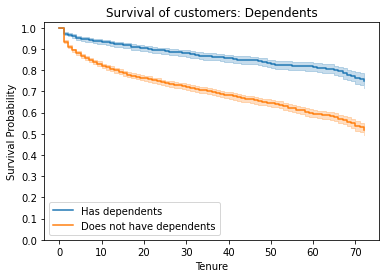

In [13]:
Dependents = (survival_data['Dependents_Yes'] == 1)
no_Dependents = (survival_data['Dependents_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Dependents],event_observed = eventvar[Dependents],label = "Has dependents")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_Dependents],event_observed = eventvar[no_Dependents],label = "Does not have dependents")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Dependents')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[Dependents], timevar[no_Dependents], event_observed_A=eventvar[Dependents], event_observed_B=eventvar[no_Dependents])
groups.print_summary()

# PhoneService

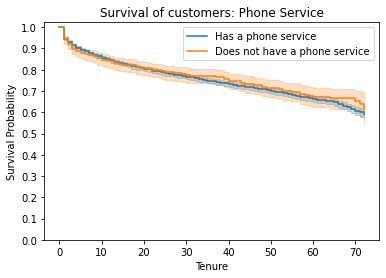

In [14]:
PhoneService = (survival_data['PhoneService_Yes'] == 1)
no_PhoneService = (survival_data['PhoneService_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[PhoneService],event_observed = eventvar[PhoneService],label = "Has a phone service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_PhoneService],event_observed = eventvar[no_PhoneService],label = "Does not have a phone service")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Phone Service')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[PhoneService], timevar[no_PhoneService], event_observed_A=eventvar[PhoneService], event_observed_B=eventvar[no_PhoneService])
groups.print_summary()

# MultipleLines

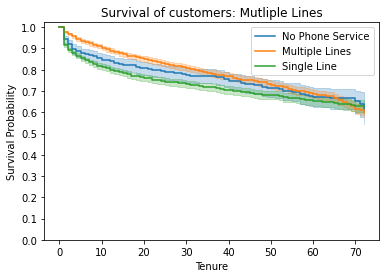

In [15]:
no_phone = (survival_data['MultipleLines_No phone service'] == 1)
multiLines = (survival_data['MultipleLines_Yes'] == 1)
no_multiLines = ((survival_data['MultipleLines_Yes'] == 0) & (survival_data['MultipleLines_No phone service'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_phone],event_observed = eventvar[no_phone],label = "No Phone Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[multiLines],event_observed = eventvar[multiLines],label = "Multiple Lines")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_multiLines],event_observed = eventvar[no_multiLines],label = "Single Line")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Mutliple Lines')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['MultipleLines'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Internet Service

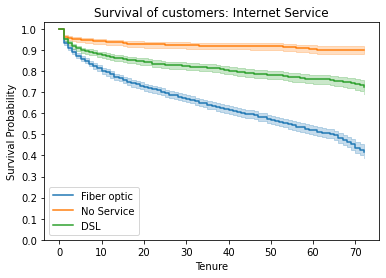

In [16]:
Fiber_optic = (survival_data['InternetService_Fiber optic'] == 1)
No_Service = (survival_data['InternetService_No'] == 1)
DSL = ((survival_data['InternetService_Fiber optic'] == 0) & (survival_data['InternetService_No'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Fiber_optic],event_observed = eventvar[Fiber_optic],label = "Fiber optic")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[No_Service],event_observed = eventvar[No_Service],label = "No Service")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[DSL],event_observed = eventvar[DSL],label = "DSL")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Internet Service')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['InternetService'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Online Security

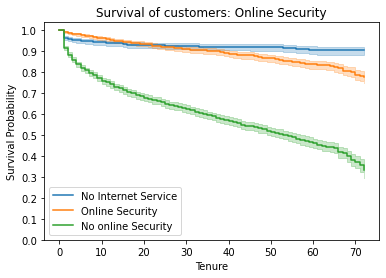

In [17]:
no_internetService = (survival_data['OnlineSecurity_No internet service'] == 1)
onlineSecurity = (survival_data['OnlineSecurity_Yes'] == 1)
no_onlineSecurity = ((survival_data['OnlineSecurity_No internet service'] == 0) & (survival_data['OnlineSecurity_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[onlineSecurity],event_observed = eventvar[onlineSecurity],label = "Online Security")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_onlineSecurity],event_observed = eventvar[no_onlineSecurity],label = "No online Security")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Online Security')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['OnlineSecurity'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# online backup

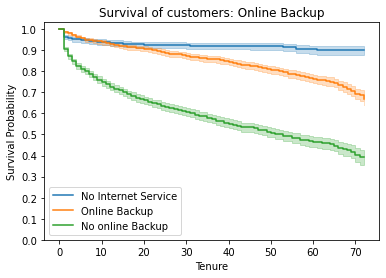

In [18]:
no_internetService = (survival_data['OnlineBackup_No internet service'] == 1)
onlineBackup = (survival_data['OnlineBackup_Yes'] == 1)
no_onlineBackup = ((survival_data['OnlineBackup_No internet service'] == 0) & (survival_data['OnlineBackup_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[onlineBackup],event_observed = eventvar[onlineBackup],label = "Online Backup")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_onlineBackup],event_observed = eventvar[no_onlineBackup],label = "No online Backup")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Online Backup')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['OnlineBackup'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Device Protection

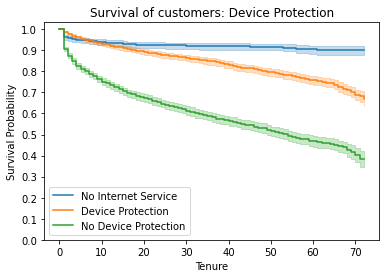

In [19]:
no_internetService = (survival_data['DeviceProtection_No internet service'] == 1)
DeviceProtection = (survival_data['DeviceProtection_Yes'] == 1)
no_DeviceProtection = ((survival_data['DeviceProtection_No internet service'] == 0) & (survival_data['DeviceProtection_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[DeviceProtection],event_observed = eventvar[DeviceProtection],label = "Device Protection")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_DeviceProtection],event_observed = eventvar[no_DeviceProtection],label = "No Device Protection")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Device Protection')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['DeviceProtection'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Tech Support

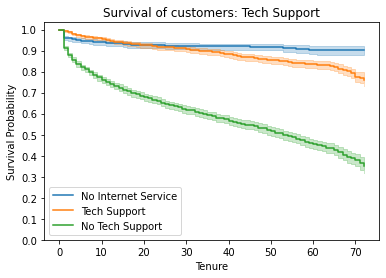

In [20]:
no_internetService = (survival_data['TechSupport_No internet service'] == 1)
TechSupport = (survival_data['TechSupport_Yes'] == 1)
no_TechSupport = ((survival_data['TechSupport_No internet service'] == 0) & (survival_data['TechSupport_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[TechSupport],event_observed = eventvar[TechSupport],label = "Tech Support")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_TechSupport],event_observed = eventvar[no_TechSupport],label = "No Tech Support")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Tech Support')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['TechSupport'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Streaming TV

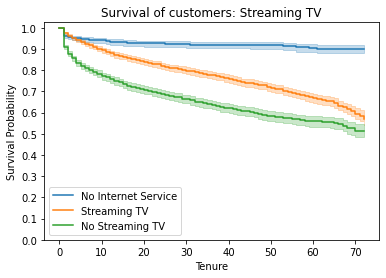

In [21]:
no_internetService = (survival_data['StreamingTV_No internet service'] == 1)
StreamingTV = (survival_data['StreamingTV_Yes'] == 1)
no_StreamingTV = ((survival_data['StreamingTV_No internet service'] == 0) & (survival_data['StreamingTV_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[StreamingTV],event_observed = eventvar[StreamingTV],label = "Streaming TV")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_StreamingTV],event_observed = eventvar[no_StreamingTV],label = "No Streaming TV")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Streaming TV')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['StreamingTV'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Streaming Movies

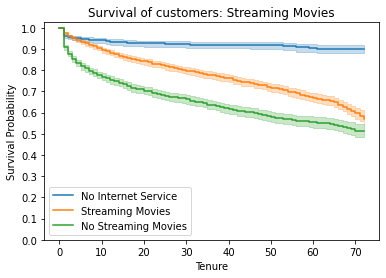

In [22]:
no_internetService = (survival_data['StreamingMovies_No internet service'] == 1)
StreamingMovies = (survival_data['StreamingMovies_Yes'] == 1)
no_StreamingMovies = ((survival_data['StreamingMovies_No internet service'] == 0) & (survival_data['StreamingMovies_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[StreamingMovies],event_observed = eventvar[StreamingMovies],label = "Streaming Movies")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_StreamingMovies],event_observed = eventvar[no_StreamingMovies],label = "No Streaming Movies")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Streaming Movies')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['StreamingMovies'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Contract

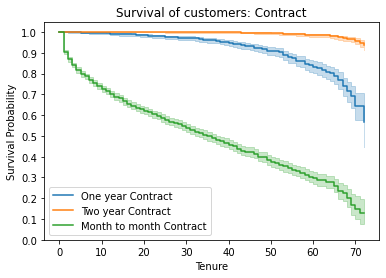

In [23]:
Contract_One_year = (survival_data['Contract_One year'] == 1)
Contract_Two_year = (survival_data['Contract_Two year'] == 1)
Contract_month_to_month = ((survival_data['Contract_One year'] == 0) & (survival_data['Contract_Two year'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Contract_One_year],event_observed = eventvar[Contract_One_year],label = "One year Contract")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[Contract_Two_year],event_observed = eventvar[Contract_Two_year],label = "Two year Contract")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[Contract_month_to_month],event_observed = eventvar[Contract_month_to_month],label = "Month to month Contract")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Contract')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['Contract'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Payment Method

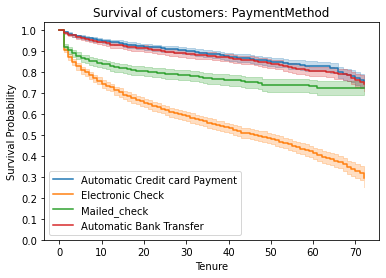

In [24]:
automatic_Credit_Card = (survival_data['PaymentMethod_Credit card (automatic)'] == 1)
electronic_check = (survival_data['PaymentMethod_Electronic check'] == 1)
mailed_check = (survival_data['PaymentMethod_Mailed check'] == 1)
automatic_Bank_Transfer = ((survival_data['PaymentMethod_Credit card (automatic)'] == 0) & (survival_data['PaymentMethod_Electronic check'] == 0) & (survival_data['PaymentMethod_Mailed check'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[automatic_Credit_Card],event_observed = eventvar[automatic_Credit_Card],label = "Automatic Credit card Payment")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[electronic_check],event_observed = eventvar[electronic_check],label = "Electronic Check")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[mailed_check],event_observed = eventvar[mailed_check],label = "Mailed_check")
plot3 = kmf.plot(ax = plot2)

kmf.fit(timevar[automatic_Bank_Transfer],event_observed = eventvar[automatic_Bank_Transfer],label = "Automatic Bank Transfer")
plot4 = kmf.plot(ax = plot3)
                 
plt.title('Survival of customers: PaymentMethod')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(data['tenure'], data['PaymentMethod'], data['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

# Paperless Billing

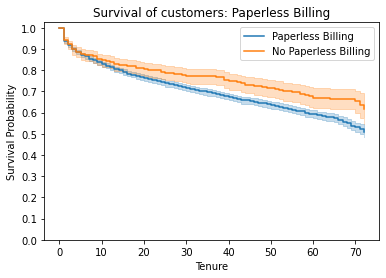

In [25]:
PaperlessBilling = (survival_data['PaperlessBilling_Yes'] == 1)
no_PaperlessBilling = (survival_data['PaperlessBilling_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[PaperlessBilling],event_observed = eventvar[PaperlessBilling],label = "Paperless Billing")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_PhoneService],event_observed = eventvar[no_PhoneService],label = "No Paperless Billing")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Paperless Billing')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[PaperlessBilling], timevar[no_PaperlessBilling], event_observed_A=eventvar[PaperlessBilling], event_observed_B=eventvar[no_PaperlessBilling])
groups.print_summary()